sajjad shokooh mosghani

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
print(f"Dataset downloaded to: {path}")

# Define paths
train_path = os.path.join(path, "images", "train")
test_path = os.path.join(path, "images", "validation")

# Check if paths exist
if not os.path.exists(train_path):
    # Try alternative structure
    train_path = os.path.join(path, "train")
    test_path = os.path.join(path, "test")

print(f"Train path exists: {os.path.exists(train_path)}")
print(f"Test path exists: {os.path.exists(test_path)}")

100%|██████████| 121M/121M [00:07<00:00, 17.4MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1
Train path exists: True
Test path exists: True


In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Create datasets
try:
    train_dataset = ImageFolder(root=train_path, transform=transform)
    test_dataset = ImageFolder(root=test_path, transform=test_transform)

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")
    print(f"Classes: {train_dataset.classes}")

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

except Exception as e:
    print(f"Error loading datasets: {e}")
    print("Trying to find images in subdirectories...")

    # Alternative: Create custom dataset
    class FacialExpressionDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

            self.image_paths = []
            self.labels = []

            for class_name in self.classes:
                class_dir = os.path.join(root_dir, class_name)
                if os.path.exists(class_dir):
                    for img_name in os.listdir(class_dir):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(os.path.join(class_dir, img_name))
                            self.labels.append(self.class_to_idx[class_name])

            print(f"Found {len(self.image_paths)} images in {root_dir}")

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label

    # Create datasets
    train_dataset = FacialExpressionDataset(train_path, transform=transform)
    test_dataset = FacialExpressionDataset(test_path, transform=test_transform)

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Number of training samples: 28821
Number of test samples: 7066
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']



Visualizing training samples...


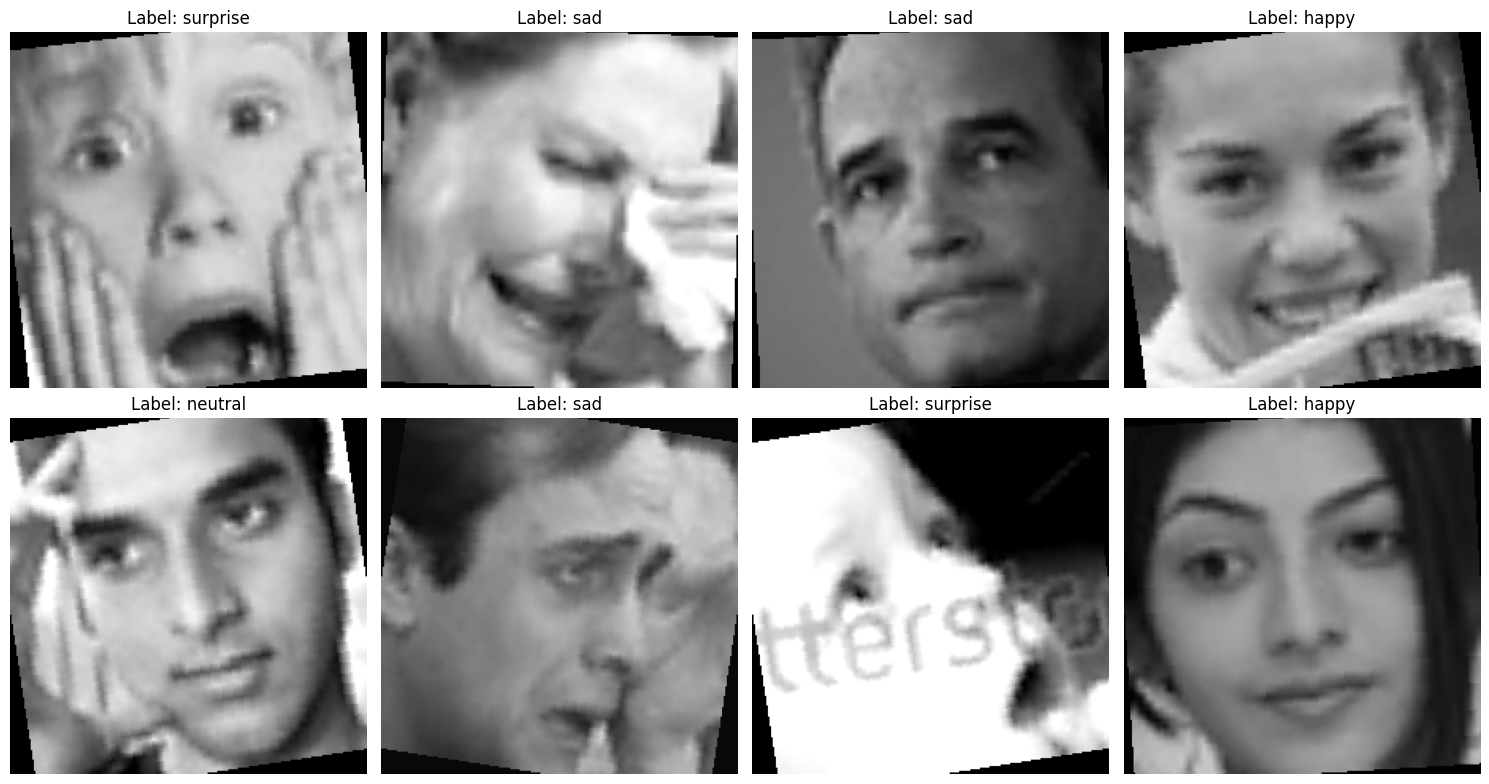

In [7]:
# Visualize some samples
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx, ax in enumerate(axes.flat):
        img, label = dataset[indices[idx]]

        # Denormalize for visualization
        img_np = img.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        ax.imshow(img_np)
        ax.set_title(f"Label: {dataset.classes[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing training samples...")
visualize_samples(train_dataset)

In [8]:
# Define the model
class FacialExpressionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FacialExpressionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Calculate size after convolutions and pooling
        # Input: 224x224 -> after 4 pooling layers: 14x14
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Alternative: Using pretrained ResNet
class FacialExpressionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(FacialExpressionResNet, self).__init__()

        # Load pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Freeze early layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Modify the final layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [9]:
# Choose model
model = FacialExpressionResNet(num_classes=7).to(device)
print("\nModel architecture:")
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]



Model architecture:
FacialExpressionResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
# Training loop
num_epochs = 5
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [15]:
print("\nStarting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, _, _ = validate_epoch(model, test_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


Starting training...
Epoch 1/5:
  Train Loss: 1.5093, Train Acc: 41.39%
  Val Loss: 1.4468, Val Acc: 45.32%
Epoch 2/5:
  Train Loss: 1.5025, Train Acc: 41.98%
  Val Loss: 1.4388, Val Acc: 45.02%
Epoch 3/5:
  Train Loss: 1.5096, Train Acc: 41.46%
  Val Loss: 1.4432, Val Acc: 45.90%
Epoch 4/5:
  Train Loss: 1.5011, Train Acc: 41.98%
  Val Loss: 1.4514, Val Acc: 45.33%
Epoch 5/5:
  Train Loss: 1.5029, Train Acc: 41.49%
  Val Loss: 1.4457, Val Acc: 45.19%


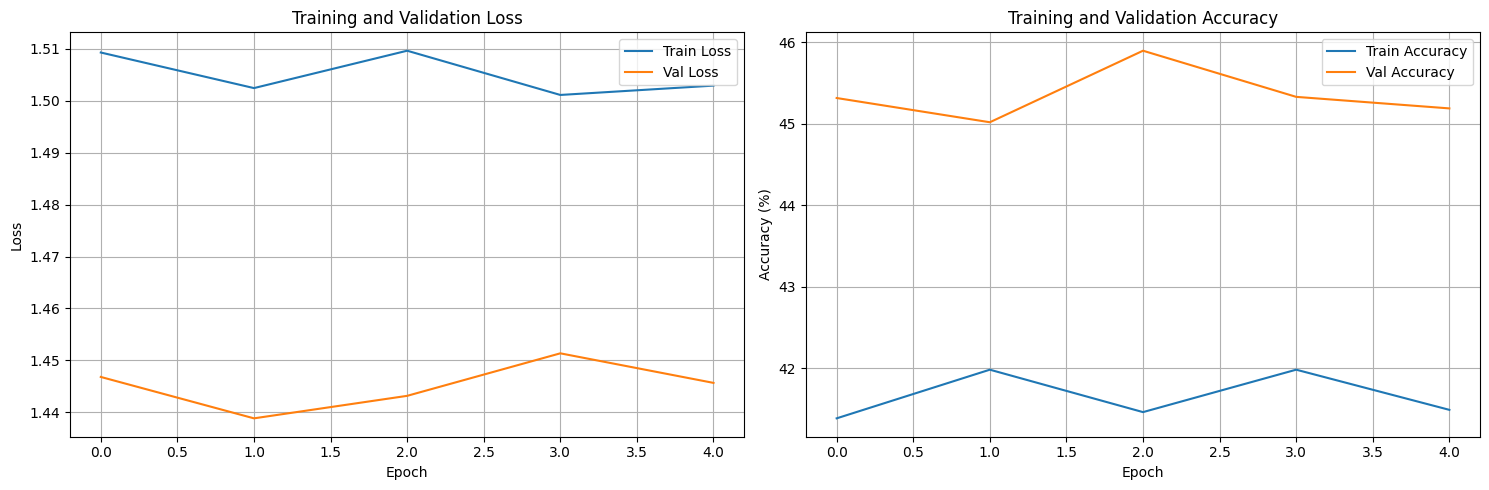

In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy')
axes[1].plot(val_accs, label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Final Evaluation:

Classification Report:
              precision    recall  f1-score   support

       angry       0.35      0.27      0.31       960
     disgust       0.00      0.00      0.00       111
        fear       0.37      0.15      0.21      1018
       happy       0.50      0.74      0.59      1825
     neutral       0.43      0.44      0.43      1216
         sad       0.36      0.37      0.36      1139
    surprise       0.62      0.59      0.61       797

    accuracy                           0.45      7066
   macro avg       0.38      0.37      0.36      7066
weighted avg       0.43      0.45      0.43      7066



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


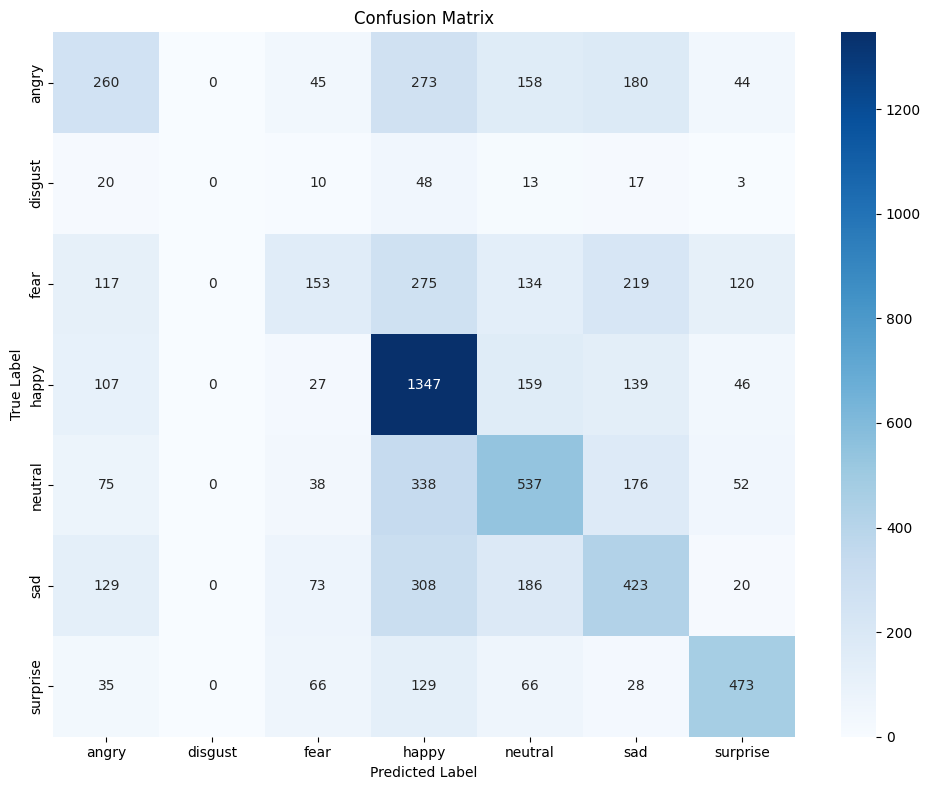


Model saved as 'facial_expression_model.pth'


In [17]:
# Final evaluation
print("\nFinal Evaluation:")
val_loss, val_acc, all_preds, all_labels = validate_epoch(model, test_loader, criterion, device)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), 'facial_expression_model.pth')
print("\nModel saved as 'facial_expression_model.pth'")

In [18]:
# Function to predict emotion from new image
def predict_emotion(image_path, model, transform, classes, device):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Get probabilities for all classes
    probs = probabilities[0].cpu().numpy()

    # Create results dictionary
    results = {
        'predicted_class': classes[predicted.item()],
        'confidence': probabilities[0][predicted.item()].item(),
        'all_probabilities': {classes[i]: probs[i] for i in range(len(classes))}
    }

    return results


Testing prediction function...

Analyzing: 31134.jpg
Predicted emotion: surprise
Confidence: 83.10%


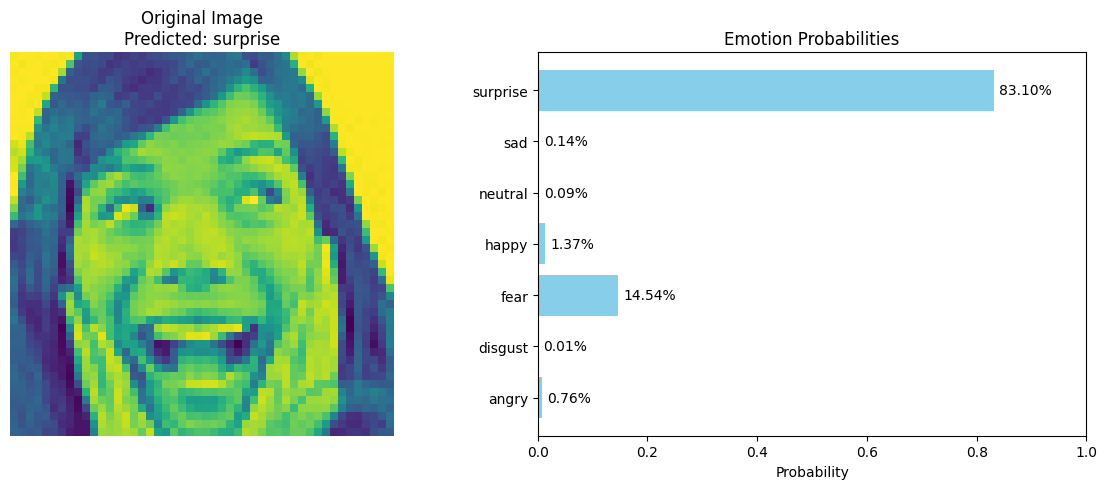


Analyzing: 32095.jpg
Predicted emotion: happy
Confidence: 60.50%


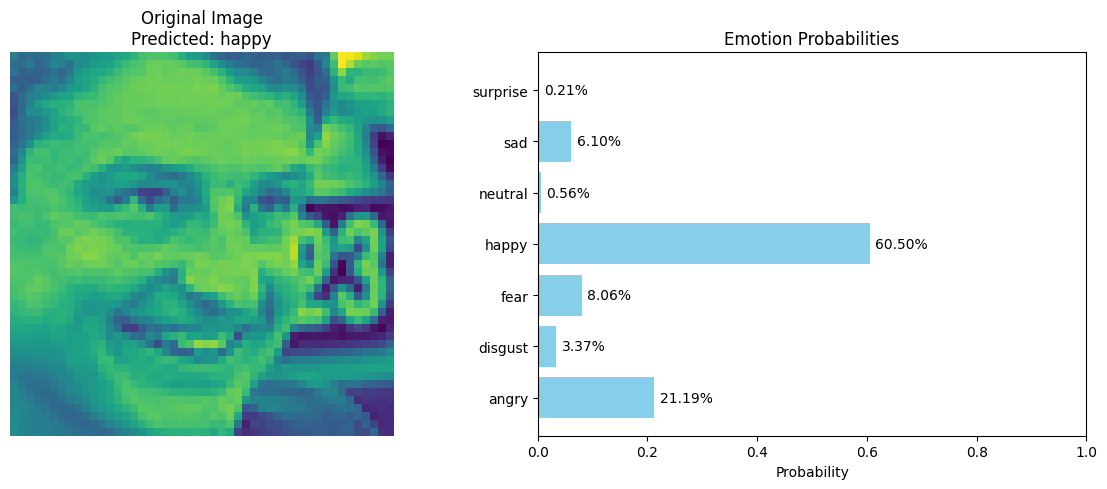


Analyzing: 17535.jpg
Predicted emotion: happy
Confidence: 31.10%


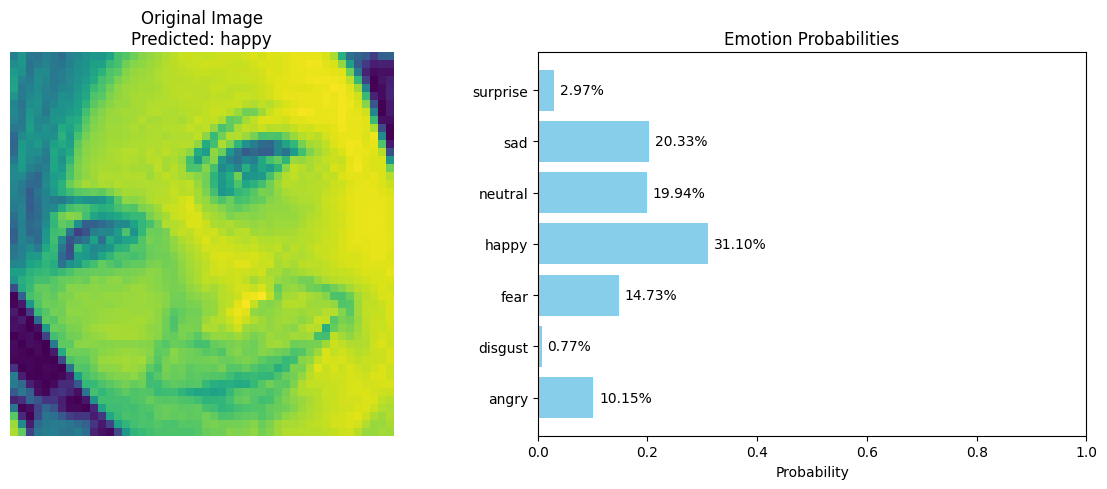

In [19]:
# Test the prediction function with a sample image
print("\nTesting prediction function...")

# Find a sample image
sample_images = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            sample_images.append(os.path.join(root, file))
            if len(sample_images) >= 5:
                break
    if len(sample_images) >= 5:
        break

if sample_images:
    for img_path in sample_images[:3]:
        print(f"\nAnalyzing: {os.path.basename(img_path)}")
        result = predict_emotion(img_path, model, test_transform, train_dataset.classes, device)
        print(f"Predicted emotion: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.2%}")

        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original image
        img = Image.open(img_path)
        axes[0].imshow(img)
        axes[0].set_title(f"Original Image\nPredicted: {result['predicted_class']}")
        axes[0].axis('off')

        # Probability bar chart
        classes = list(result['all_probabilities'].keys())
        probs = list(result['all_probabilities'].values())

        bars = axes[1].barh(classes, probs, color='skyblue')
        axes[1].set_xlabel('Probability')
        axes[1].set_title('Emotion Probabilities')
        axes[1].set_xlim([0, 1])

        # Add probability values on bars
        for bar, prob in zip(bars, probs):
            width = bar.get_width()
            axes[1].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{prob:.2%}', va='center')

        plt.tight_layout()
        plt.show()
else:
    print("No sample images found for testing.")



In [20]:
# Create a simple inference class for real-time use
class FacialExpressionAnalyzer:
    def __init__(self, model_path=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

        # Define transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load model
        self.model = FacialExpressionResNet(num_classes=7).to(self.device)

        if model_path and os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            print(f"Model loaded from {model_path}")
        else:
            print("Using trained model from memory")

    def analyze_image(self, image_path):
        """Analyze emotion from image file"""
        result = predict_emotion(image_path, self.model, self.transform, self.classes, self.device)
        return result

    def analyze_frame(self, frame):
        """Analyze emotion from numpy array frame (for real-time video)"""
        # Convert numpy array to PIL Image
        if isinstance(frame, np.ndarray):
            frame = Image.fromarray(frame)

        self.model.eval()
        image_tensor = self.transform(frame).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

        probs = probabilities[0].cpu().numpy()

        return {
            'predicted_class': self.classes[predicted.item()],
            'confidence': probabilities[0][predicted.item()].item(),
            'probabilities': {self.classes[i]: probs[i] for i in range(len(self.classes))}
        }


In [21]:
# Example usage of the analyzer
print("\nCreating Facial Expression Analyzer...")
analyzer = FacialExpressionAnalyzer('facial_expression_model.pth')

print("\nFacial Expression Recognition System Ready!")
print("==========================================")
print("Emotions recognized:")
for i, emotion in enumerate(analyzer.classes):
    print(f"  {i+1}. {emotion.capitalize()}")
print("\nUse analyzer.analyze_image('path/to/image.jpg') to analyze emotions")


Creating Facial Expression Analyzer...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from facial_expression_model.pth

Facial Expression Recognition System Ready!
Emotions recognized:
  1. Angry
  2. Disgust
  3. Fear
  4. Happy
  5. Neutral
  6. Sad
  7. Surprise

Use analyzer.analyze_image('path/to/image.jpg') to analyze emotions
